Import basic stuff

In [42]:
%matplotlib inline

import os
import sys
import settings
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from django_pandas.io import read_frame
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates

from matplotlib.dates import date2num


In [43]:
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'rest.settings')
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
django.setup()

In [44]:
sid = 500820
from stocks.models import Listing, Stock

In [45]:
stock = Stock.objects.get(security=sid)
print(stock)

ASIAN PAINTS LTD.


In [46]:
listings = Listing.objects.filter(stock=stock)
print(len(listings))

5322


Transorm the data for plotting

In [47]:
dates = list(map(lambda d: d.date.date(), listings))

In [48]:
closing = list(map(lambda d:d.closing, listings))

In [49]:
df = read_frame(listings, index_col='date')

In [50]:
for column in df.columns:
    if column != 'stock':
       df[column] = pd.to_numeric(df[column]) 

In [51]:
df = df.sort_index()
df.columns

Index(['id', 'opening', 'high', 'low', 'closing', 'wap', 'traded', 'trades',
       'turnover', 'deliverable', 'ratio', 'spread_high_low',
       'spread_close_open', 'stock'],
      dtype='object')

In [52]:
df = df.reindex(columns = ['opening', 'high', 'low', 'closing', 'traded'])
df.rename(columns={"opening": "Open", "high": "High", "low": "Low", "closing":"Close", "traded":"Volume"}, inplace=True)

In [53]:
df = df.loc['2015-10-13':'2021-12-31']

<AxesSubplot:xlabel='date'>

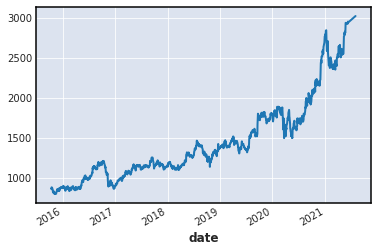

In [54]:
df['Close'].plot()

* Load up minutewise data of Nifty
* Chop it into baskets of days
* For each day, find the maximum and also the hover levels at around 1:00pm
* Hypotheses is that Short Covering happens nearly every day around 1pm, or 2pm - and particularly on days where morning half sees a good upward rally and little downward rally.
* So, if morning has been in strong uptrend, what is the statistical frequency of a 'significant' short-covering
* With entry around 1/1:15pm at spot, how many point movement can be expected?
* What should be the stop-loss?

Try to find the local maxima and minima for finding support and resistance.

[Link](https://towardsdatascience.com/detection-of-price-support-and-resistance-levels-in-python-baedc44c34c9)

In [55]:
#from mplfinance.original_flavor import candlestick_ohlc
#import matplotlib.dates as mpl_dates
plt.rcParams['figure.figsize'] = [20, 13]
plt.rc('font', size=14)

In [56]:
df.index = pd.to_datetime(df.index)
df.tail()

,Open,High,Low,Close,Volume
date,,,,,
2021-06-08,2922.70,2944.65,2906.90,2928.1,73054
2021-06-09,2936.00,2964.95,2920.40,2944.1,124701
2021-06-11,2969.00,2969.95,2939.20,2957.1,58856
2021-06-14,2961.95,2970.00,2916.55,2948.1,33431
2021-08-03,3010.00,3064.95,2996.95,3027.3,104743


In [57]:
#Try to find support and resistance by identifying the fractal pattern.
def isSupport(df,i):
  support = df['Low'][i] < df['Low'][i-1]  and df['Low'][i] < df['Low'][i+1] and df['Low'][i+1] < df['Low'][i+2] and df['Low'][i-1] < df['Low'][i-2]
  return support

def isResistance(df,i):
  resistance = df['High'][i] > df['High'][i-1]  and df['High'][i] > df['High'][i+1] and df['High'][i+1] > df['High'][i+2] and df['High'][i-1] > df['High'][i-2]
  return resistance

In [58]:
levels = []
for i in range(2,df.shape[0]-2):
  if isSupport(df,i):
    levels.append((i,df['Low'][i]))
  elif isResistance(df,i):
    levels.append((i,df['High'][i]))

In [59]:
def plot_all(df, levels):
  fig, ax = plt.subplots()
  candlestick_ohlc(ax,df.values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  fig.tight_layout()
  for level in levels:
    plt.hlines(level[1],xmin=df['date'][level[0]],\
               xmax=max(df['date']),colors='blue')
  fig.show()

In [60]:
from matplotlib.dates import date2num
df_1 = df.reset_index()
df_1['date'] = date2num(df_1['date'])
df_1.head()

,date,Open,High,Low,Close,Volume
0,16721.0,863.00,867.50,858.00,865.65,58715
1,16722.0,865.30,869.15,859.60,862.60,32967
2,16723.0,865.05,877.50,865.05,869.35,70905
3,16724.0,869.50,884.00,865.95,882.20,67592
4,16727.0,885.00,892.00,868.55,879.05,66274


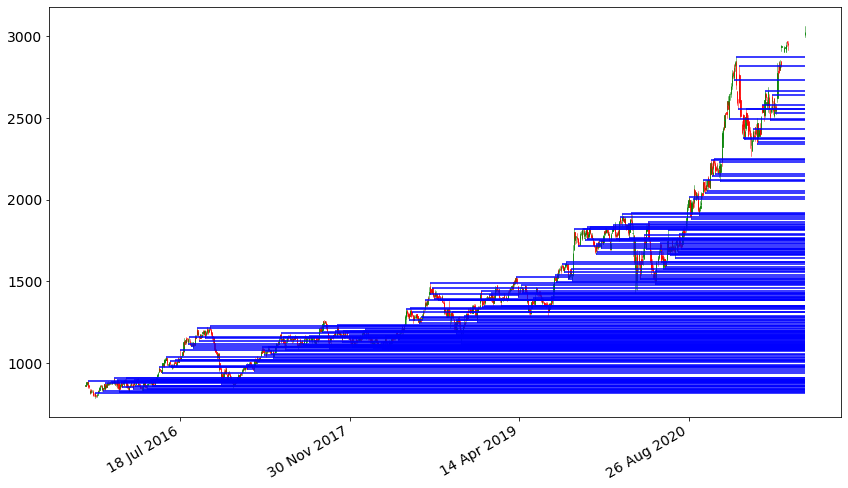

In [20]:
plot_all(df_1, levels)

In [61]:
def isFarFromLevel(l, margin, levels):
  return np.sum([abs(l-x) < margin  for x in levels]) == 0

In [62]:
margin =  np.mean(df_1['High'] - df_1['Low'])

In [63]:
levels = []
for i in range(2,df_1.shape[0]-2):
  if isSupport(df_1,i):
    l = df['Low'][i]

    if isFarFromLevel(l, margin, levels):
      levels.append((i,l))

  elif isResistance(df_1,i):
    l = df['High'][i]

    if isFarFromLevel(l, margin, levels):
      levels.append((i,l))

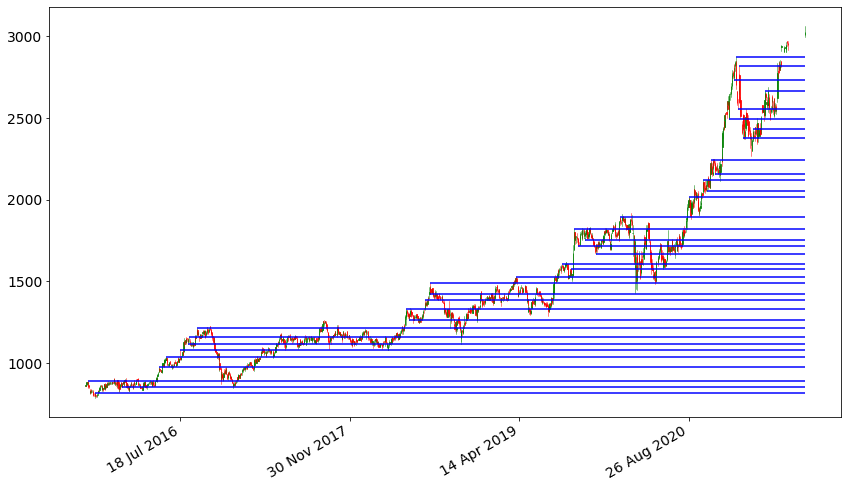

In [24]:
plot_all(df_1, levels)

/mnt/c/Users/anshu/Documents/experimental/env/lib/python3.8/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


<Mpf_Figure size 3000x1700 with 0 Axes>

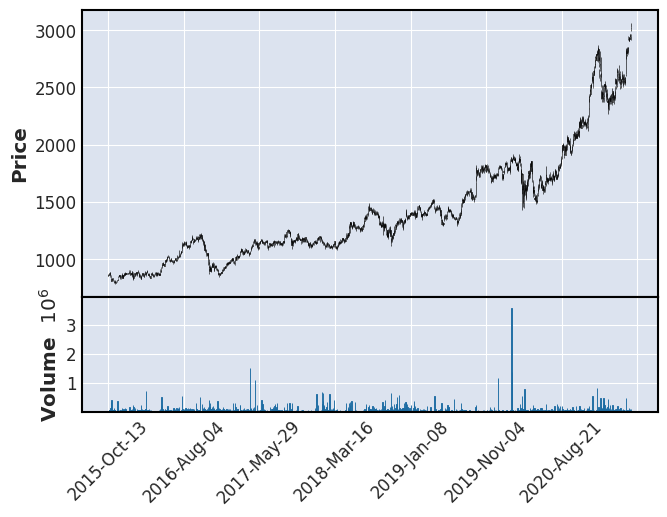

In [64]:
import mplfinance as mpf
df_2 = df.loc['2015-10-13':'2021-12-31']
s = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 6})
fig = mpf.figure(figsize=(30, 17), style=s)
mpf.plot(df_2,type='candle', volume=True)

In [65]:
def ma(type='SMA', length=20, df=None):
    if df==None:
        print('Dataframe not provided.')
        return None
    if type=='SMA':
        df['SMA'+str(length)]=df['Close'].rolling(length).mean()
        df.dropna(inplace=True)
    elif type=='EMA':
        df['SMA'+str(length)]=df['Close'].ewm(span=length).mean()
        df.dropna(inplace=True)
    return df
        
    

In [66]:
#Compute moving averages
df['SMA20'] = df['Close'].rolling(30).mean()
# removing all the NULL values using 
# dropna() method
df.dropna(inplace=True)

In [67]:
df['EMA20'] = df['Close'].ewm(span=30).mean()
df.dropna(inplace=True)

In [68]:
#Try to find maxima and minima.
def isMinima(df,i, field='EMA_SMA'):
  minima = df[field][i] < df[field][i-1]  and df[field][i] < df[field][i+1]
  return minima

def isMaxima(df,i):
  maxima = df[field][i] > df[field][i-1]  and df[field][i] > df[field][i+1]
  return maxima

In [69]:
#Compute EMA of SMA
sma = df['Close'].rolling(10).mean()
df['EMA_SMA']= sma.ewm(alpha=0.2).mean()
df.dropna(inplace=True)

/mnt/c/Users/anshu/Documents/experimental/env/lib/python3.8/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


<Mpf_Figure size 1200x1000 with 0 Axes>

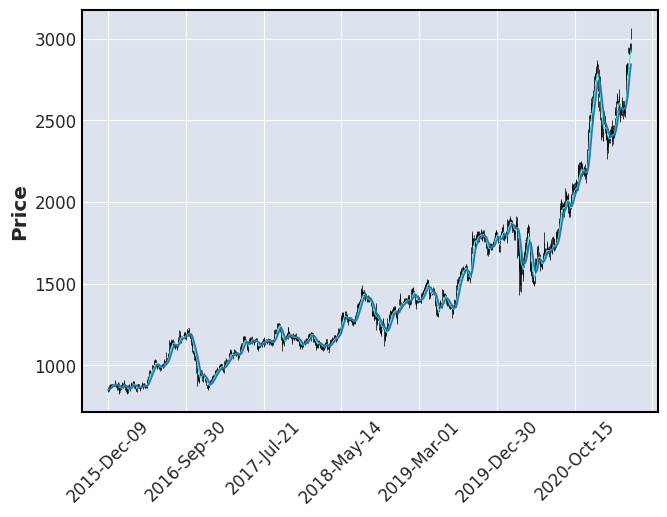

In [70]:
def plot_composite(df):
    #fig = mpf.figure(style='yahoo', figsize=(12,10))
    #ax1 = fig.add_subplot(2,1,1)
    #ax2 = ax1.twinx()
    #ap = mpf.make_addplot(df['EMA_SMA'],ax=ax2)
    #mpf.plot(df,ax=ax1, addplot=ap,xrotation=10)
    #fig.show()
    fig = mpf.figure(style='yahoo', figsize=(12,10))
    ap = mpf.make_addplot(df['EMA_SMA'])
    mpf.plot(df, mav=10, addplot = ap)
    
    #fig, ax = plt.subplots()
    #candlestick_ohlc(ax,df.values,width=0.6, \
    #                   colorup='green', colordown='red', alpha=0.8)
    #date_format = mpl_dates.DateFormatter('%d %b %Y')
    #ax.xaxis.set_major_formatter(date_format)
    #fig.autofmt_xdate()
    #fig.tight_layout()
    #plt.plot()
    #fig.show()

plot_composite(df)

In [85]:
from pandas.tseries.frequencies import to_offset

logic = {'Open'  : 'first',
         'High'  : 'max',
         'Low'   : 'min',
         'Close' : 'last',
         'Volume': 'sum'}
#Resample on weekly levels
df_weekly = df.resample('W').apply(logic)
df_weekly.index -= to_offset("6D")

margin =  np.mean(df_weekly['High'] - df_weekly['Low'])
print(margin)

76.33000000000001


In [86]:
#Find maximas and minimas on the EMA values now
import numpy as np
min_levels = [np.nan]
max_levels = [np.nan]

for i in range(1,df.shape[0]-1):
  if isMinima(df,i):
    #min_levels.append((i,df['EMA_SMA'][i]))
    #min_levels.append(df['EMA_SMA'][i]*0.99)
    if isFarFromLevel(df['EMA_SMA'][i], margin, min_levels):
        min_levels.append(df['EMA_SMA'][i]*0.99)
    else:
        min_levels.append(np.nan)
  else:
    min_levels.append(np.nan)
  if isMaxima(df,i):
    #max_levels.append((i,df['EMA_SMA'][i]))
    #max_levels.append(df['EMA_SMA'][i]*1.01)
    if isFarFromLevel(df['EMA_SMA'][i], margin, max_levels):
      max_levels.append(df['EMA_SMA'][i]*1.01)
    else:
      max_levels.append(np.nan)  
  else:
    max_levels.append(np.nan)

min_levels.append(np.nan)
max_levels.append(np.nan)    

In [87]:
def plot_all(df, levels):
  fig, ax = plt.subplots()
  candlestick_ohlc(ax,df.values,width=0.6, \
                   colorup='green', colordown='red', alpha=0.8)
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)
  fig.autofmt_xdate()
  fig.tight_layout()
  for level in levels:
    plt.hlines(level[1],xmin=df['date'][level[0]],\
               xmax=max(df['date']),colors='blue')
  fig.show()

In [88]:
df.head()

,Open,High,Low,Close,Volume,SMA20,EMA20,EMA_SMA
date,,,,,,,,
2015-12-09,860.0,864.75,837.00,840.25,52282,829.348333,850.183147,850.300000
2015-12-10,842.0,860.00,842.00,858.95,51950,830.385000,851.271211,850.147222
2015-12-11,861.2,862.90,846.95,856.40,85036,831.353333,851.871950,850.043852
2015-12-14,855.0,877.00,853.45,874.20,95662,832.835000,854.356527,851.136721
2015-12-15,876.0,878.60,866.00,876.30,92709,834.421667,856.689232,852.736637


/mnt/c/Users/anshu/Documents/experimental/env/lib/python3.8/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


<Mpf_Figure size 1200x1000 with 0 Axes>

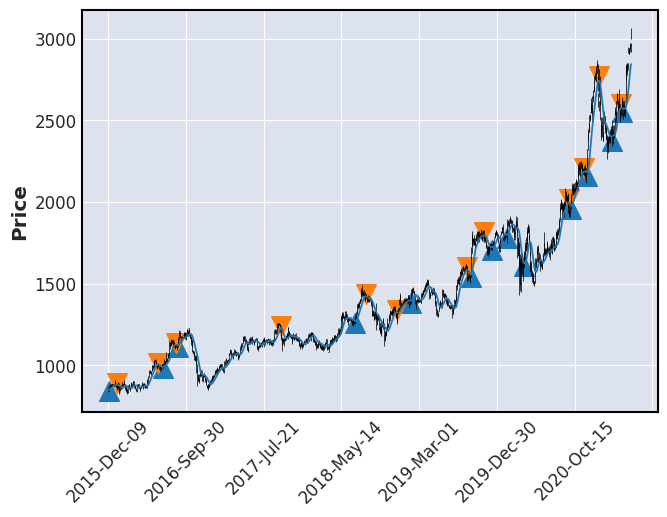

In [90]:
from matplotlib.dates import date2num
#df_1 = df.reset_index()
#df_1['date'] = date2num(df_1['date'])
#df_1.head()

#plot_all(df_1, levels)
fig = mpf.figure(style='yahoo', figsize=(12,10))

#print(len(min_levels))
#print(len(max_levels))
#print(len(df))
ap = [mpf.make_addplot(df['EMA_SMA']),
      mpf.make_addplot(min_levels, type='scatter', markersize=200,marker='^'),
      mpf.make_addplot(max_levels, type='scatter', markersize=200,marker='v')]
mpf.plot(df, addplot = ap)

In [117]:
df['A2'] = df['EMA_SMA'] - 2*df['EMA_SMA'].shift(1) + df['EMA_SMA'].shift(2)
df['A1'] = df['EMA_SMA'] - df['EMA_SMA'].shift(1)

min_levels = [np.nan]
max_levels = [np.nan]


#Try to find maxima and minima.
def isMinima(df,i, field='EMA_SMA'):
  #minima = df['A1'][i] == 0 and df['A2'] > 0
  minima =  df['A1'][i] < df['A1'][i-1]  and df['A1'][i] < df['A1'][i+1]
  return minima

def isMaxima(df,i, field = 'EMA_SMA'):
  #maxima = df['A1'][i] == 0 and df['A2'] < 0
  maxima = df['A1'][i] > df['A1'][i-1]  and df['A1'][i] > df['A1'][i+1]
  return maxima

for i in range(1,df.shape[0]-1):
  if isMinima(df,i, field='A1'):
    #min_levels.append((i,df['EMA_SMA'][i]))
    #min_levels.append(df['EMA_SMA'][i]*0.99)
    if isFarFromLevel(df['EMA_SMA'][i], margin, min_levels):
        min_levels.append(df['EMA_SMA'][i]*0.99)
    else:
        min_levels.append(np.nan)
  else:
    min_levels.append(np.nan)
  if isMaxima(df,i, field='A1'):
    #max_levels.append((i,df['EMA_SMA'][i]))
    #max_levels.append(df['EMA_SMA'][i]*1.01)
    if isFarFromLevel(df['EMA_SMA'][i], margin, max_levels):
      max_levels.append(df['EMA_SMA'][i]*1.01)
    else:
      max_levels.append(np.nan)  
  else:
    max_levels.append(np.nan)

min_levels.append(np.nan)
max_levels.append(np.nan)    

/mnt/c/Users/anshu/Documents/experimental/env/lib/python3.8/site-packages/mplfinance/_arg_validators.py:35: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


<Mpf_Figure size 1200x1000 with 0 Axes>

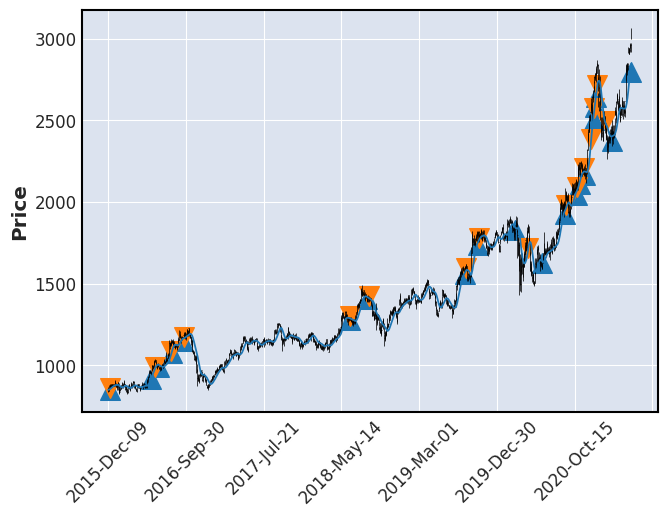

In [118]:
fig = mpf.figure(style='yahoo', figsize=(12,10))
#ap = [mpf.make_addplot(df['EMA_SMA']),
#      mpf.make_addplot(df['A2']),]
#mpf.plot(df, addplot = ap)
#df['A2'][0:200].plot()

#print(len(min_levels))
#print(len(max_levels))
#print(len(df))

ap = [mpf.make_addplot(df['EMA_SMA']),
      mpf.make_addplot(min_levels, type='scatter', markersize=200,marker='^'),
      mpf.make_addplot(max_levels, type='scatter', markersize=200,marker='v')]
mpf.plot(df, addplot = ap)